### Les outils nécessaires

In [1]:
#Outils nécessaires
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
from time import perf_counter
%matplotlib inline
import seaborn
seaborn.set()

### Illustration du principe Gradient Boosting

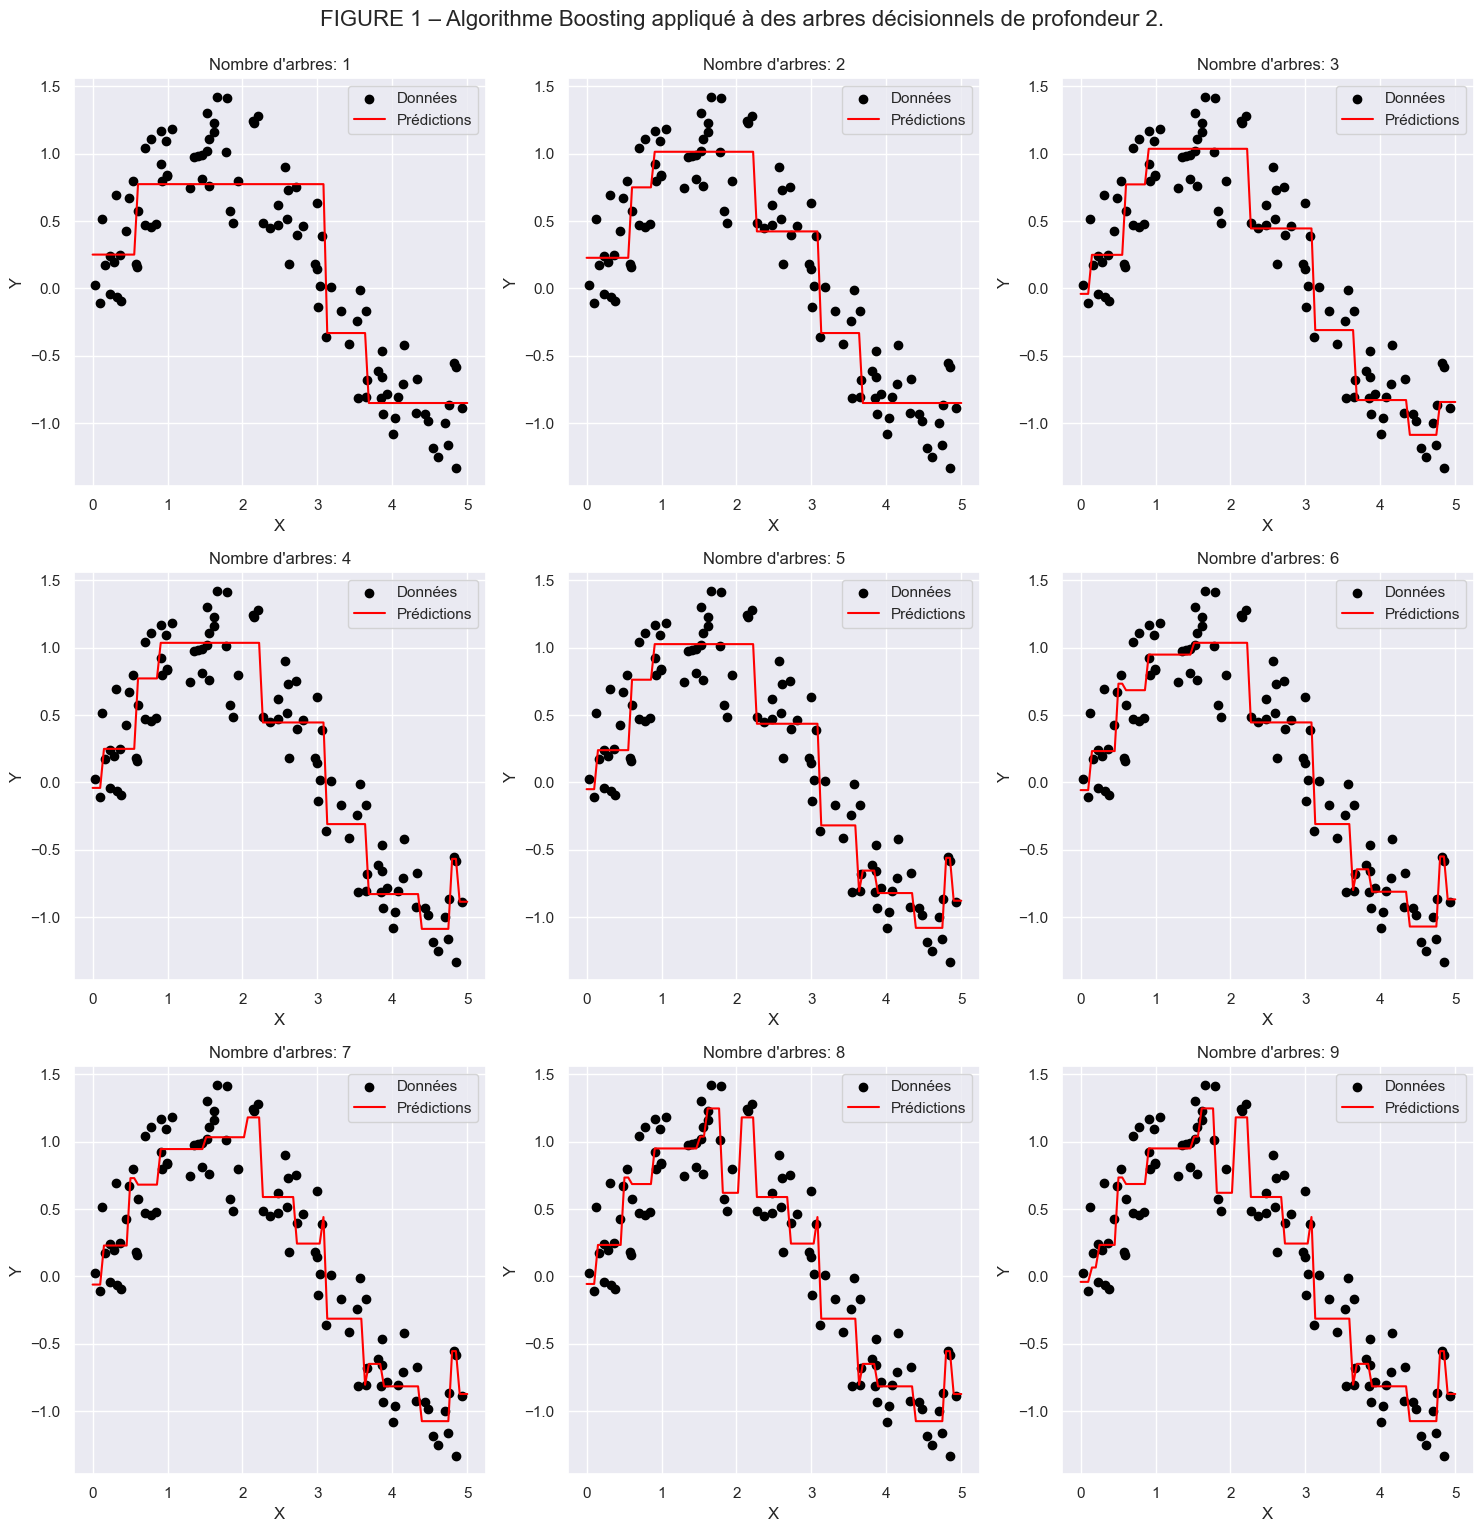

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

# 1. Simulation des données
np.random.seed(42)
n_samples = 100
X = np.random.uniform(0, 5, size=(n_samples, 1))
epsilon = np.random.uniform(-0.5, 0.5, size=n_samples) * (np.random.rand(n_samples) < 4/5)
Y = np.sin(X.flatten()) + epsilon

# Définir les paramètres du modèle de boosting
max_trees = 9
learning_rate = 1.0
max_depth = 2

# Créer un espace pour les prédictions
x_range = np.linspace(0, 5, 100).reshape(-1, 1)

# Initialisation de la figure pour les sous-figures
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

# Itérer pour différents nombres d'arbres
for n_trees in range(1, max_trees + 1):
    # Créer un modèle de boosting avec `n_trees` arbres
    boosting_regressor = GradientBoostingRegressor(n_estimators=n_trees, 
                                                   max_depth=max_depth, 
                                                   learning_rate=learning_rate, 
                                                   loss='squared_error')
    boosting_regressor.fit(X, Y)
    Y_pred = boosting_regressor.predict(x_range)

    # Tracer les résultats
    ax = axes[n_trees - 1]
    ax.scatter(X, Y, color='black', label='Données')
    ax.plot(x_range, Y_pred, color='red', label='Prédictions')
    ax.set_title(f'Nombre d\'arbres: {n_trees}')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.legend()

# Ajuster les espacements
plt.tight_layout()
fig.suptitle("FIGURE 1 – Algorithme Boosting appliqué à des arbres décisionnels de profondeur 2.", fontsize=16, y=1.02)
# Enregistrer la figure
plt.savefig("boosting_decision_tree.png", dpi=300, bbox_inches='tight')
plt.show()

## Sommaire

### 1. Critères de coûts
- Moindres carrés
- Least-Absolute Deviation
- K-class multinomial negative log-likelihood

### 2. Classe Gradient Boosting par arbre (Tree Boost)

### 3. Un exemple jouet
- LS TreeBoost
- LAD TreeBoost
- La force de l'aggrégation

### 4. MNIST dataset

### 5. Diabetes dataset

## Critères de perte

Cette section est dédiée à l'introduction des différentes fonctions de coûts $\psi : \mathbb{R} \times \mathbb{R} \to \mathbb{R}^+$ que nous utiliserons au fil du notebook.

## 1)le MSE

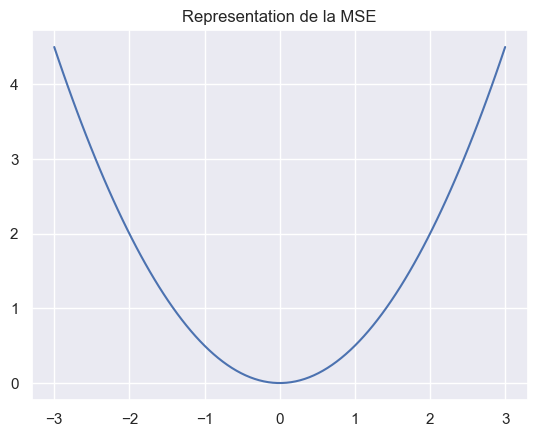

In [3]:
def mse(y,F):
    """
        Parameters:
        - y : array of length n = size_of_dataset
        - F : array of evaluations of the current Fhat estimator in the data X associated to y
    """
    return 0.5*(y-F)**2

def grad_mse(y,F):
    return((F-y))

plt.plot(np.linspace(-3,3,100),mse(np.linspace(-3,3,100),np.zeros(100)))
plt.title('Representation de la MSE');

## 2) Least-absolute deviation <a id="part1sec2"></a>

$$\forall x, y \in \mathbb{R}, \ \psi(x, y) = |x - y|.$$

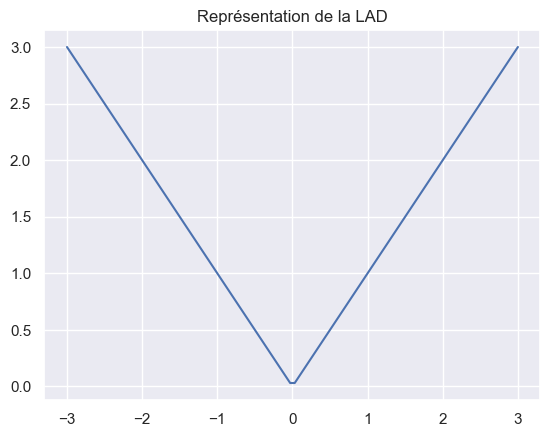

In [4]:
def lad(y,F):
    """
        Parameters:
        - y : array of length n = size_of_dataset
        - F : array of evaluations of the current Fhat estimator in the data X associated to y
    """
    return(np.abs(y-F)) #return an array

def grad_lad(y,F):
    grad = (F-y) #sign inverted because we compute the gradient in the F variable
    grad[grad > 0] = 1 
    grad[grad < 0] = - 1
    return(grad)

plt.plot(np.linspace(-3,3,100), lad(np.linspace(-3,3,100), np.zeros(100)))
plt.title('Représentation de la LAD');

## 3) K-class multinomial negative log-likelihood <a id="part1sec4"></a>

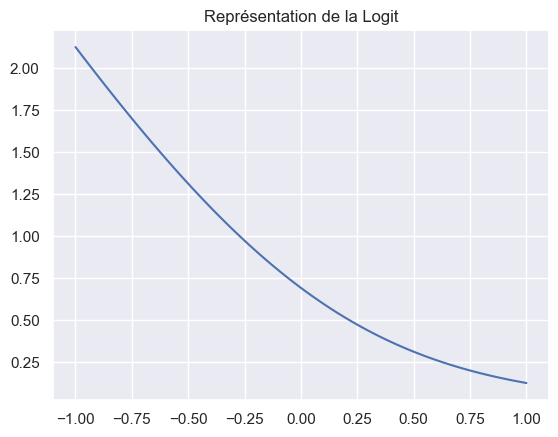

In [5]:
#Binomial negative log likelihood (2 class) 
def Bl(y,F):
    return np.log(1 + np.exp(-2*y*F))

def grad_Bl(y,F):
    return((-2*y*np.exp(-2*y*F)) / (1 + np.exp(-2*y*F)))

plt.plot(np.linspace(-1,1,100), Bl(np.linspace(-1,1,100), np.ones(100)))
plt.title('Représentation de la Logit');

# GradientBoostingTree <a id="part2"></a>

On dispose d'un jeu de données d'entraînement $\mathcal D_n := \{(\mathbf X_1,Y_1),(\mathbf X_2,Y_2),...,(\mathbf X_n,Y_n)\}$ contenant $n$ paires $(\mathbf X,Y) \in \mathcal{X} \times \mathcal{Y}$ de variables aléatoires (v.a.) où $\mathcal{X} \subset \mathbb R^d$ et $\mathcal{Y} = \{-1;1\}$ pour un problème de classification binaire ou $\mathcal{Y} = \mathbb R$ pour un problème de régression. \\
On suppose les données $\mathcal D_n$ indépendantes et identiquement distribuées (i.i.d.) et la v.a. $Y \in \mathbb R$ de carré intégrable, i.e. $\mathbb E{Y^2} < \infty$.

**But:** Dans ce cours on s'intéresse à l'estimation de la fonction $f^*: \mathcal{X} \to \mathcal{Y}$ par l'algorithme Stochastic Gradient Boosting et solution du problème

\begin{equation}
    \label{eq:argmin}
    f^* = \arg \min_{F \in \mathcal F} \mathbb{E}\left[\psi(Y, f(\mathbf X))\right]
\end{equation}
où $\mathcal F$ est l'espace des fonctions de $\mathcal{X} \to \mathcal{Y}$.

Le principe est de résoudre ce problème d'optimisation de façon incrémentale en procédeant en une combinaison de faible apprenant. Par itérations successives, la connaissance d'un apprenant faible - weak learner - est ajoutée au classifieur final, appelé strong classifier.

L'approche par la méthode `GradientBoostingTree` consiste à considérer des arbres CART comme apprenants de base. Pour cela, on utilisera en particulier la méthode `DecisionTreeRegressor`de `scikit-learn` comme apprenants faibles. Une classe pour une méthode boosting par arbre est implémentée ci-dessous :

In [6]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np

class GradientBoostingTree(object):
    def __init__(self, loss, learning_rate, n_estimators=10, criterion='friedman_mse', max_depth=3, max_samples=1.0, alpha=0.9):
        """
        Initialise les paramètres du modèle de Gradient Boosting Tree.

        Parameters :
        - loss : Fonction de perte utilisée pour l'optimisation. 
                 'LS' pour la perte quadratique, 
                 'LAD' pour la perte absolue, 
                 'Huber' pour la perte Huber,
                 'LK' pour la log-vraisemblance négative (binaire).
        - learning_rate : Taux d'apprentissage (réel entre 0 et 1). Plus faible signifie des mises à jour plus petites.
        - n_estimators : Nombre total d'estimateurs (arbres de régression) à utiliser dans le modèle.
        - criterion : Critère utilisé pour la mesure de la qualité de la division des arbres. Options : 'squared_error', 'friedman_mse', 'absolute_error'.
        - max_depth : Profondeur maximale des arbres de régression (complexité des arbres).
        - max_samples : Proportion d'échantillons à utiliser pour entraîner chaque arbre.
                        Si max_samples=1.0, utilise le bootstrap (échantillonnage avec remplacement).
                        Si max_samples < 1.0, utilise un échantillonnage aléatoire et extrait max_samples x n points (où n est le nombre total de points).
        - alpha : Paramètre de la perte Huber. Définit le seuil delta pour différencier les résidus importants des résidus faibles.
        """
        # Parameters of GradientTreeBoosting
        self.loss = loss
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.max_depth = max_depth
        self.max_samples = max_samples
        self.alpha = alpha

    def starter(self, X, y):
        """
        Initialise le modèle en calculant les prédictions initiales et en préparant les données pour l'entraînement.

        Parameters :
        - X : Matrice des caractéristiques d'entraînement.
        - y : Vecteur des cibles d'entraînement.

        Retourne :
        - self : Instance du modèle avec les valeurs initiales définies.
        """
        # Conversion de X en tableau 2D
        data = np.asarray(X)
        if data.ndim == 1:
            data = data[:, np.newaxis]

        self.n_data = data.shape[0]  # Taille de l'échantillon
        self.n_sample = int(self.max_samples * self.n_data)  # Nombre d'échantillons pour l'échantillonnage aléatoire
        self.y = y
        self.data = data

        self.estimators_ = []  # Liste pour stocker les arbres de régression
        self.regions_train_ = []  # Liste pour stocker les régions des arbres d'entraînement
        self.regions_ = []  # Liste pour stocker les régions des arbres pour les nouvelles données
        self.F = []  # Liste des prédictions cumulées

        # Initialisation de F_0
        if self.loss == 'LS':
            self.init = np.mean(self.y)  # Moyenne des cibles pour la perte quadratique

        if self.loss == 'LAD' or self.loss == 'Huber':
            self.init = np.median(self.y)  # Médiane des cibles pour la perte absolue ou Huber

        if self.loss == 'LK':
            self.init = 0.5 * np.log((1 + np.mean(self.y)) / (1 - np.mean(self.y)))  # Initialisation pour la log-vraisemblance négative

        self.F.append(self.init * np.ones(self.n_data))  # Initialisation de F_0

        return self

    def predict(self, X):
        """
        Effectue des prédictions pour les nouvelles données en utilisant le modèle entraîné.

        Parameters :
        - X : Matrice des caractéristiques pour les nouvelles données.

        Retourne :
        - pred : Vecteur des prédictions pour les nouvelles données.
        """
        # Conversion de X en tableau 2D
        X = np.asarray(X)
        if X.ndim == 1:
            X = X[:, np.newaxis]

        N_pred = X.shape[0]  # Number of predictions
        pred = self.init * np.ones(N_pred)  # Tableau des prédictions initialisé avec la valeur de base

        # Construction et application des arbres de régression
        for t in range(self.n_estimators):
            # 1 : Échantillonnage des données
            if self.max_samples == 1:
                idx = np.arange(self.n_data)  # Utilisation de l'ensemble complet sans échantillonnage
            else:
                idx = np.random.permutation(self.n_data)[:self.n_sample]  # Échantillonnage aléatoire des indices

            y_sample = self.y[idx]
            data_sample = self.data[idx]
            F = self.F[-1]
            F_sample = F[idx]

            # 2 : Calcul des résidus pseudo y_tilde
            if self.loss == 'LS':
                y_tilde = y_sample - F_sample  # Résidus pour la perte quadratique
                self.estimators_.append(DecisionTreeRegressor(criterion=self.criterion, max_depth=self.max_depth))
                self.estimators_[-1].fit(data_sample, y_tilde)  # Entraînement de l'arbre sur les résidus
                F_sample = F_sample + self.learning_rate * self.estimators_[-1].predict(data_sample)  # Mise à jour des prédictions
                pred = pred + self.learning_rate * self.estimators_[-1].predict(X)  # Mise à jour des prédictions pour les nouvelles données

            elif self.loss == 'LAD':
                # y_tilde is the sign of residuals y - F
                y_tilde = y_sample - F_sample
                y_tilde[y_tilde > 0] = 1
                y_tilde[y_tilde < 0] = -1

                # On calcule gamma pour chaque région
                self.estimators_.append(DecisionTreeRegressor(criterion=self.criterion, max_depth=self.max_depth))
                self.estimators_[-1].fit(data_sample, y_tilde)  # Entraînement de l'arbre sur les signes des résidus
                self.regions_train_.append(self.estimators_[-1].apply(data_sample))
                self.regions_.append(self.estimators_[-1].apply(X))
                R_train = self.regions_train_[-1]  # Régions pour les données d'entraînement
                IDR = np.unique(R_train)  # Identifiants uniques des régions
                R = self.regions_[-1]
                # Gamma
                gamma = []
                for l in IDR:
                    idl = np.argwhere(R_train == l)
                    y_l = y_sample[idl]
                    F_l = F_sample[idl]
                    gamma.append(np.median(y_l - F_l))
                    F_sample[idl] = F_sample[idl] + self.learning_rate * gamma[-1]  # Mise à jour des prédictions

                for k in range(N_pred):
                    l = R[k]  # Région de x_new
                    i = np.argwhere(IDR == l)[0][0]
                    pred[k] = pred[k] + self.learning_rate * gamma[i]  # Prédiction pour chaque nouvel échantillon

            elif self.loss == 'Huber':
                # Calcul de delta_m
                r = y_sample - F_sample  # Résidus actuels
                delta = np.quantile(np.abs(r), self.alpha)  # Calcul du seuil delta
                y_tilde = r
                y_tilde[r > delta] = delta
                y_tilde[r < -delta] = -delta

                # Regions
                self.estimators_.append(DecisionTreeRegressor(criterion=self.criterion, max_depth=self.max_depth))
                self.estimators_[-1].fit(data_sample, y_tilde)  # Entraînement de l'arbre sur les résidus Huber
                self.regions_train_.append(self.estimators_[-1].apply(data_sample))
                self.regions_.append(self.estimators_[-1].apply(X))
                R_train = self.regions_train_[-1]
                IDR = np.unique(R_train)
                R = self.regions_[-1]
                # Gamma
                gamma = []
                for l in IDR:
                    idl = np.argwhere(R_train == l)
                    r_l = r[idl]
                    r_tilde = np.median(r_l)
                    r_ = r_l - r_tilde

                    r_min = np.abs(r_)
                    r_min[r_min > delta] = delta
                    r_min[r_ < 0] = -r_min[r_ < 0]

                    gamma.append(r_tilde + np.sum(r_min) / len(idl))
                    F_sample[idl] = F_sample[idl] + self.learning_rate * gamma[-1]  # Mise à jour des prédictions

                for k in range(N_pred):
                    l = R[k]  # région de x_new
                    i = np.argwhere(IDR == l)[0][0]
                    pred[k] = pred[k] + self.learning_rate * gamma[i]  # Prédiction pour chaque nouvel échantillon

            elif self.loss == 'LK':
                marge = 2 * y_sample * F_sample
                if np.sum(1 * (marge > 709)) > 0:
                    marge[marge > 709] = 709

                y_tilde = (2 * y_sample) / (1 + np.exp(marge))

                # Regions
                self.estimators_.append(DecisionTreeRegressor(criterion=self.criterion, max_depth=self.max_depth))
                self.estimators_[-1].fit(data_sample, y_tilde)  # Entraînement de l'arbre sur les résidus LK
                self.regions_train_.append(self.estimators_[-1].apply(data_sample))
                self.regions_.append(self.estimators_[-1].apply(X))
                R_train = self.regions_train_[-1]
                IDR = np.unique(R_train)
                R = self.regions_[-1]
                # Gamma
                gamma = []
                for l in IDR:
                    idl = np.argwhere(R_train == l)
                    gamma.append(np.sum(y_tilde[idl] / np.sum(np.abs(y_tilde[idl]) * (2 - np.abs(y_tilde[idl])))))
                    F_sample[idl] = F_sample[idl] + self.learning_rate * gamma[-1]  # Mise à jour des prédictions

                for k in range(N_pred):
                    l = R[k]  # région de x_new
                    i = np.argwhere(IDR == l)[0][0]
                    pred[k] = pred[k] + self.learning_rate * gamma[i]  # Prédiction pour chaque nouvel échantillon

            F[idx] = F_sample
            self.F.append(F)  # Stockage des prédictions mises à jour

        if self.loss == 'LK':
            pred = 2 * (pred > 0) - 1  # Transformation des prédictions en labels binaires

        return pred

    def error(self, X, y):
        """
        Calcule l'erreur du modèle sur un ensemble de données donné.

        Parameters :
        - X : Matrice des caractéristiques pour les données de test.
        - y : Vecteur des cibles pour les données de test.

        Retourne :
        - erreur : Erreur du modèle calculée en fonction de la fonction de perte.
        """
        # Conversion de X en tableau 2D
        X = np.asarray(X)
        if X.ndim == 1:
            X = X[:, np.newaxis]
        if self.loss == 'LK':
            err = np.mean(1 * (self.predict(X) * y < 0))  # Erreur de classification pour la perte LK
        else:
            err = np.mean((y - self.predict(X)) ** 2)  # Erreur quadratique moyenne pour les autres fonctions de perte

        return err

    

## Un exemple jouet <a id="part3"></a>

Pour une première compréhension du concept de Boosting, on utilisera un jeu de données $\mathcal{D}_n$ issues d'un modèle très simple basé sur la fonction $x \mapsto \sin(x)$. On se restreint, pour cela à un espace d'observation $\mathcal X = [0;5]$ et $\mathcal Y = \mathbb R$ de dimensions $1$. On considère le modèle de régression suivant :
$$Y = f(X) + \varepsilon,$$

où $X \sim \mathcal U_{[0;5]}, \varepsilon \sim \mathcal U_{[-0.5;0.5]}$ avec probabilité $p=\frac{1}{5}$, $\varepsilon = 0$ sinon et $f = \sin$.

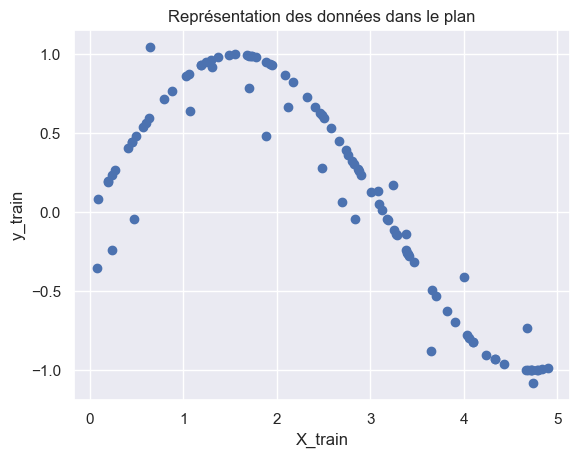

In [7]:
# Génération d'un ensemble de données de régression
n = 100 # Nombre d'échantillons
X_train = np.sort(5 * np.random.rand(n))  # Variables aléatoires dans l'intervalle [0, 5]
y_train = np.sin(X_train)  # Valeurs cibles avec une fonction sinus
# Ajout de bruit aux valeurs cibles (environ 20% des valeurs)
y_train[::5] += 1 * (0.5 - np.random.rand(n//5))# Ajouter du bruit aléatoire aux échantillons tous les 5 indices
# Génération des données de test
X_test = np.arange(0, 5, step=1e-2)# Création d'un ensemble de test avec un pas de 0.01
y_test = np.sin(X_test) # Valeurs cibles pour l'ensemble de test

# Transformation en tableaux 2D pour la compatibilité avec les modèles
X_train = X_train[:, np.newaxis]
X_test = X_test[:, np.newaxis]
# Visualisation des données d'entraînement
plt.scatter(X_train, y_train)# Affichage des points de données d'entraînement
plt.xlabel('X_train')  # Étiquette de l'axe des x
plt.ylabel('y_train')  # Étiquette de l'axe des y
plt.title('Représentation des données dans le plan');

## Least-Squares Tree Boosting <a id="part3sec1"></a>

Pour ce premier cas, on consdère $\psi$ comme la fonction de coût moindres carrés i.e. $\psi(x,y) = \|x-y\|_2^2 \, \forall x,y \in \mathcal Y$. Les courbes d'erreurs en apprentissage sont alors données par les lignes de code suivantes :

Text(0.5, 0.98, 'FIGURE 3 – Évaluation du modèle Least Squares Gradient Boosting (LS-TreeBoost) version déterministe (ρ = 1, pour K = 3) en fonction du pas dapprentissage ν.')

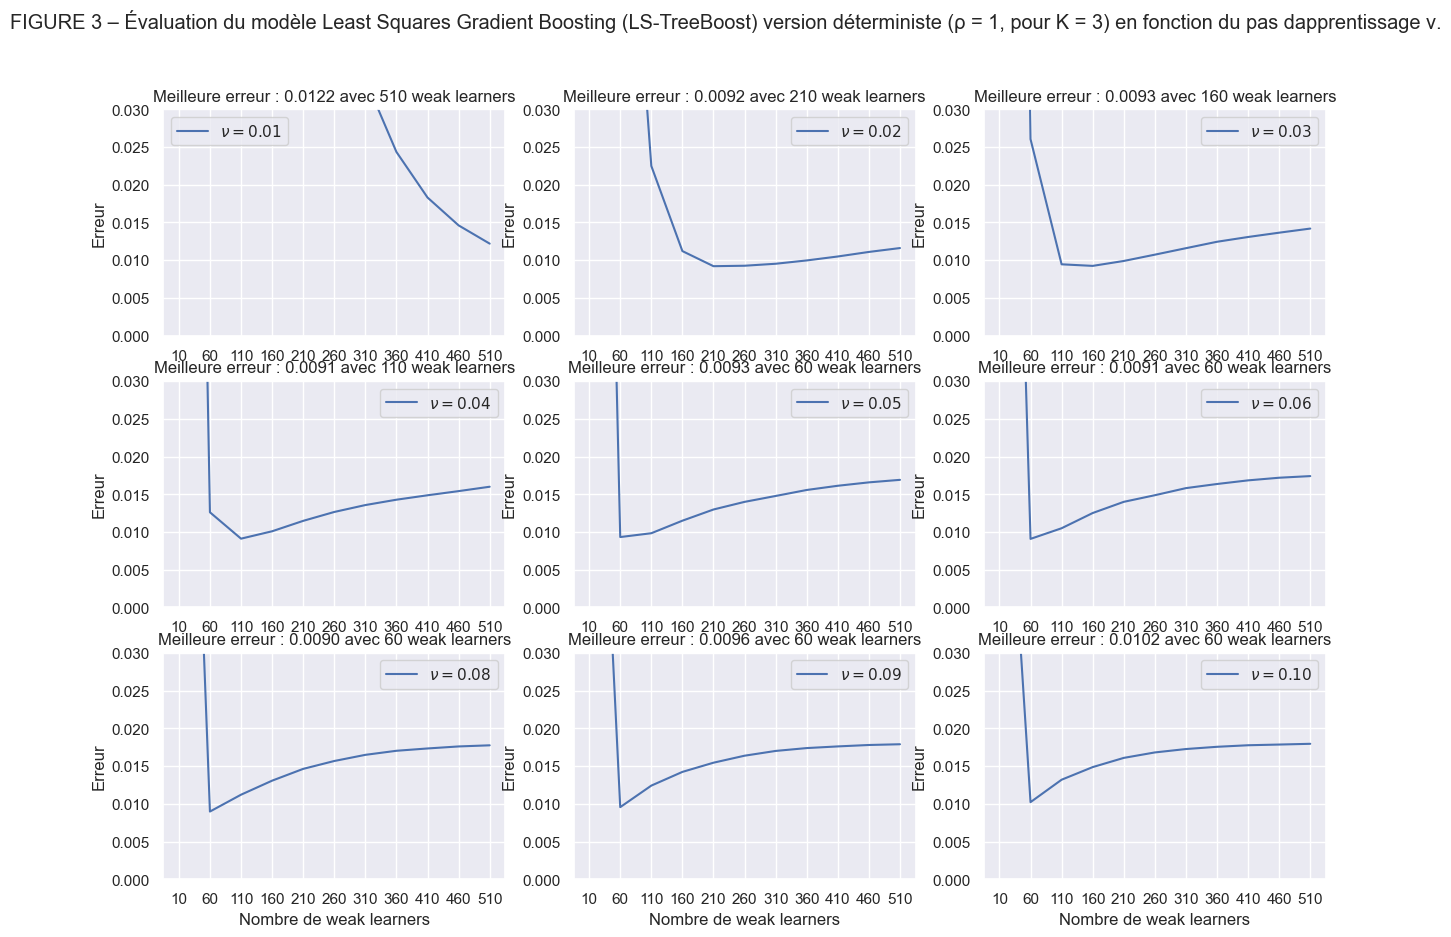

In [8]:
seed = 42
np.random.seed(seed)
#Nu représente les différentes valeurs de taux d'apprentissage (learning rate).
#N_est représente les différents nombres d'estimateurs (weak learners).
# Définir les valeurs de learning rate (nu) et de nombre d'estimateurs (N_est)
Nu = np.linspace(0.005,0.1, 9)# 9 valeurs entre 0.005 et 0.1
N_est = np.arange(10,520,50) # Valeurs de 10 à 510 avec un pas de 50


plt.figure(figsize=(15,10)) # Créer une figure de taille 15x10
# Boucle sur chaque valeur de learning rate (nu)
for it,nu in enumerate(Nu): #Pour chaque valeur de nu, un modèle GradientBoostingTree est créé et entraîné avec le nombre d'estimateurs n_est.
#L'erreur sur les données de test est calculée et stockée.
    
    plt.subplot(3,3,it+1) # Ajouter un subplot 3x3 pour chaque valeur de nu
    err = [] # Liste pour stocker les erreurs pour chaque n_est
    # Boucle sur chaque nombre d'estimateurs
    for n_est in N_est:  
         # Initialiser et entraîner le modèle GradientBoostingTree
        reg = GradientBoostingTree(loss='LS',learning_rate=nu, n_estimators=n_est, criterion='friedman_mse', max_depth=3, max_samples=1)
        reg.starter(X_train,y_train)
        err.append(reg.error(X_test,y_test)) # Calculer l'erreur sur les données de test et l'ajouter à la liste
    i_min = np.argmin(np.array(err))# Trouver l'indice de l'erreur minimale
    plt.plot(N_est, err, label= fr'$\nu = {nu:.2f}$')# Tracer les erreurs en fonction du nombre d'estimateurs
    if it > 5 : # Ajouter des étiquettes pour les axes x et y si l'itération est supérieure à 5
        plt.xlabel('Nombre de weak learners')
    plt.xticks(N_est, [str(N) for N in N_est])  # Ajouter les ticks sur l'axe x
    plt.ylabel('Erreur')
    plt.ylim(0,0.03) # Limiter l'axe y de 0 à 0.03
     # Ajouter un titre indiquant la meilleure erreur et le nombre d'estimateurs correspondant
    plt.title(f'Meilleure erreur : {err[i_min]:.4f} avec {N_est[i_min]:d} weak learners')
    plt.legend() # Ajouter une légende
plt.suptitle('FIGURE 3 – Évaluation du modèle Least Squares Gradient Boosting (LS-TreeBoost) version déterministe (\u03C1 = 1, pour K = 3) en fonction du pas dapprentissage \u03BD.')# Ajouter un titre principal à la figure
#plt.tight_layout();

Rémarque:Pour chaque valeur de m (proportion d'échantillons) et nu (taux d'apprentissage), un modèle GradientBoostingTree est créé et entraîné avec le nombre d'estimateurs n_est.
L'erreur sur les données de test est calculée et stockée.

Tracé des résultats :

Les erreurs sont tracées en fonction du nombre d'estimateurs.
Les meilleurs résultats (erreurs minimales) sont mis en évidence.
Des étiquettes et des titres sont ajoutés pour améliorer la lisibilité du graphique.

Ce code permet de visualiser l'erreur en fonction du nombre d'estimateurs pour différentes valeurs de taux d'apprentissage et de proportions d'échantillons, offrant ainsi une comparaison des performances des modèles en fonction de ces hyperparamètres



La version stochastique du Gradient Boosting est engagée lorsque l'utilisateur fixe la proportion $\rho$ des données $\mathcal D_n$ à utiliser lors du sous échantillonnage aléatoire. Voici les courbes d'erreur que l'on peut espérer en fonction du pas d'apprentissage $\nu$ et de la proportion $\rho$ choisie.

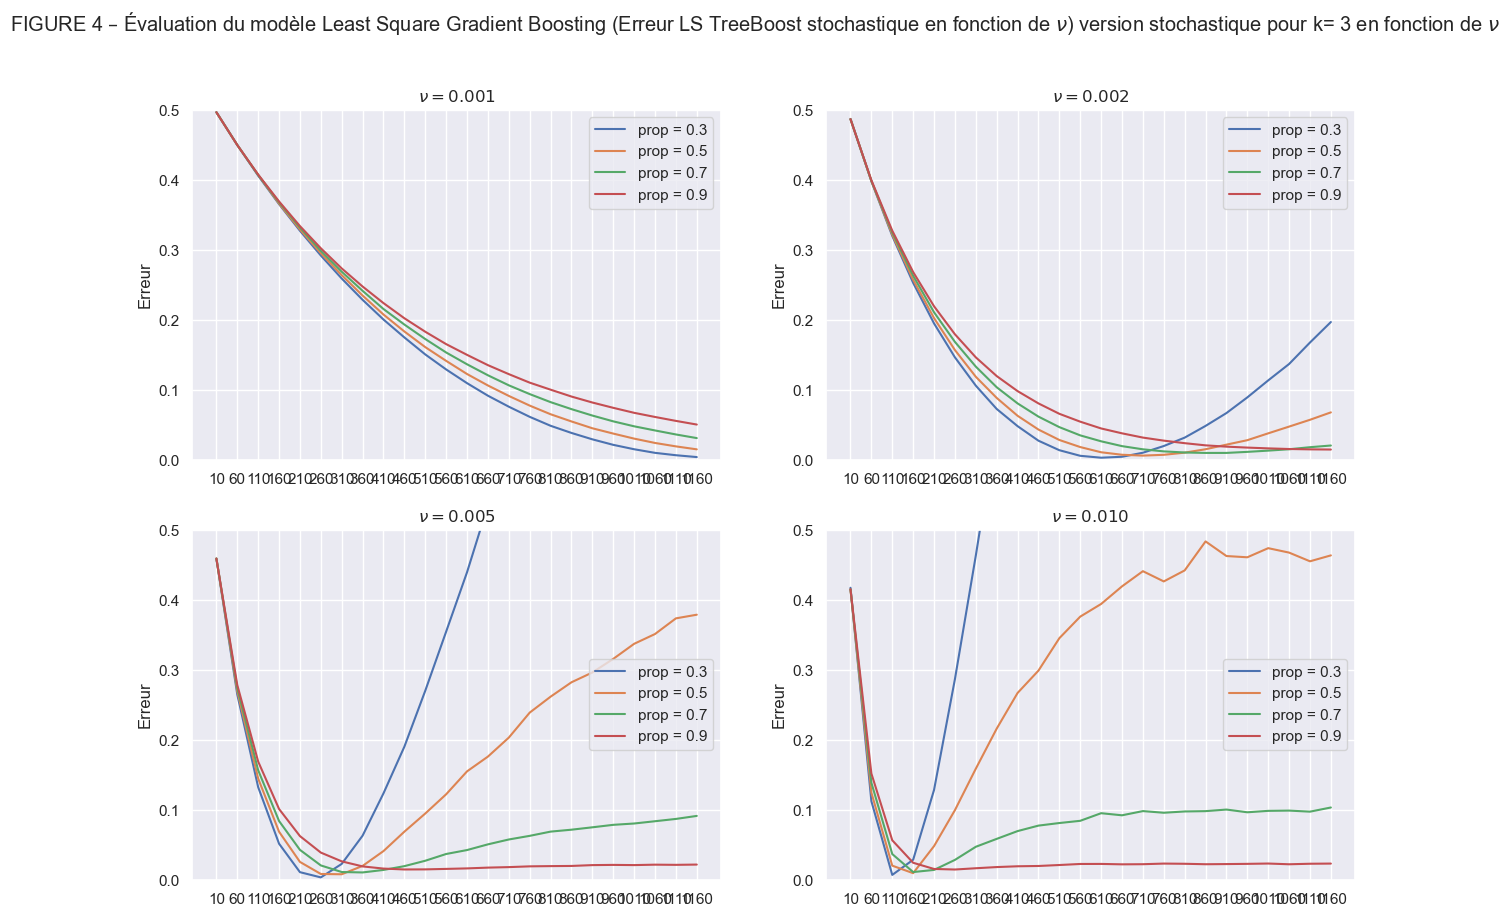

In [9]:
np.random.seed(seed)
# Définir les proportions d'échantillons, les learning rates (nu), et le nombre d'estimateurs (N_est)
Max_samples = [0.3,0.5,0.7,0.9]
Nu = [0.001,0.002,0.005,0.01] #np.linspace(0.001,0.1, 5)
N_est = np.arange(10,1200,50)

plt.figure(figsize=(15,10))# Créer une figure de taille 15x10

for m in Max_samples: # Boucle sur chaque valeur de proportion d'échantillons
    for it,nu in enumerate(Nu): # Boucle sur chaque valeur de learning rate (nu)
        plt.subplot(2,2,it+1)# Ajouter un subplot 2x2 pour chaque valeur de nu
        err = [] # Liste pour stocker les erreurs pour chaque n_est
        for n_est in N_est:  # Boucle sur chaque nombre d'estimateurs 
             # Initialiser et entraîner le modèle GradientBoostingTree
            reg = GradientBoostingTree(loss='LS',learning_rate=nu, n_estimators=n_est, criterion='friedman_mse', max_depth=9, max_samples=m)
            reg.starter(X_train,y_train)
            err.append(reg.error(X_test,y_test))# Calculer l'erreur sur les données de test et l'ajouter à la liste
        i_min = np.argmin(np.array(err)) # Trouver l'indice de l'erreur minimale
        plt.plot(N_est, err, label=f'prop = {m:.1f}') # Tracer les erreurs en fonction du nombre d'estimateurs
         # Ajouter des étiquettes pour les axes x et y si l'itération est supérieure à 5
        if it > 5 :
            plt.xlabel('Nombre de weak learners')
        plt.xticks(N_est, [str(N) for N in N_est]) # Ajouter les ticks sur l'axe x
        plt.ylabel('Erreur')
        plt.ylim(0,0.5)# Limiter l'axe y de 0 à 0.5
        plt.title(fr'$\nu = {nu:.3f}$') # Ajouter un titre indiquant la valeur de nu
        plt.legend() # Ajouter une légende
    plt.suptitle(r'FIGURE 4 – Évaluation du modèle Least Square Gradient Boosting (Erreur LS TreeBoost stochastique en fonction de $\nu$) version stochastique pour k= 3 en fonction de $\nu$');# Ajouter un titre principal à la figure
    #FIGURE 4 – Évaluation du modèle Least Square Gradient Boosting (LS-TreeBoost) version stochastique pour k= 3 en fonction du learning rate ν
#plt.tight_layout();

Rémarque:Pour chaque valeur de m (proportion d'échantillons) et nu (taux d'apprentissage), un modèle GradientBoostingTree est créé et entraîné avec le nombre d'estimateurs n_est. L'erreur sur les données de test est calculée et stockée.

Ce code permet de visualiser l'erreur en fonction du nombre d'estimateurs pour différentes valeurs de taux d'apprentissage et de proportions d'échantillons, offrant ainsi une comparaison des performances des modèles en fonction de ces hyperparamètres.

De façon plus qualitative, on peut se convaincre du bon entraînement de nos modèles en traçant l'approximation faites par ces derniers.

Time :0.8955 sec
Time :1.8019 sec
Time :2.5789 sec
Time :3.3162 sec


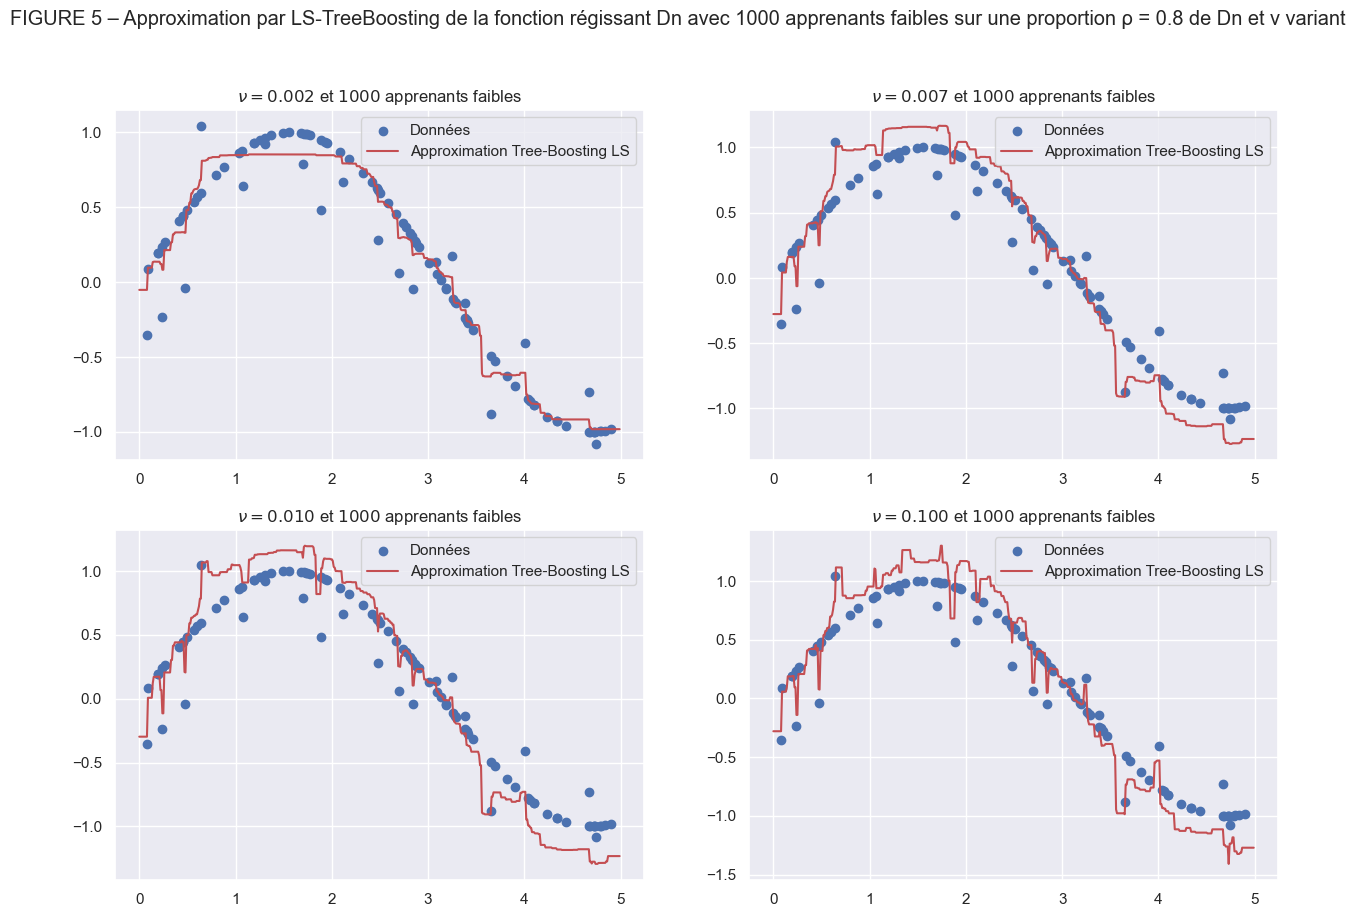

In [10]:
# Définir la graine pour assurer la reproductibilité
np.random.seed(seed)
# Définir les valeurs de taux d'apprentissage (nu) et le nombre d'apprenants faibles
Nu = [0.002, 0.007, 0.01, 0.1] #Nu représente les différentes valeurs de taux d'apprentissage (learning rate).
N_weak_learners = 1000 #représente le nombre d'apprenants faibles.
prop = 0.8 #prop représente la proportion d'échantillons à utiliser pour chaque arbre
t0 = perf_counter()# Démarrer le chronomètre

plt.figure(figsize=(15,5*math.ceil(len(Nu)/2)))# Créer une figure de taille 15x5*ceil(len(Nu)/2)
# Boucle sur chaque valeur de nu
for it,nu in enumerate(Nu):
     # Ajouter un subplot 2x2 pour chaque valeur de nu
    plt.subplot(math.ceil(len(Nu)/2),2,it+1)
    # Initialiser et entraîner le modèle GradientBoostingTree
    reg = GradientBoostingTree(loss='LS',learning_rate=nu, n_estimators=N_weak_learners, criterion='friedman_mse', max_depth=3, max_samples=prop)
    reg.starter(X_train, y_train)
    y_pred_mse = reg.predict(X_test)# Prédire les valeurs sur les données de test
    #Tracer les données d'entraînement et l'approximation Tree-Boosting LS
    plt.scatter(X_train, y_train, label = 'Données')
    plt.plot(X_test, y_pred_mse, 'r',label='Approximation Tree-Boosting LS')
     # Ajouter un titre au subplot
    plt.title(fr"$\nu ={nu:.3f}$ et ${N_weak_learners}$ apprenants faibles")
    plt.legend()
    # Afficher le temps écoulé
    t1 = perf_counter()
    print(f'Time :{t1-t0:.4f} sec')
plt.suptitle("FIGURE 5 – Approximation par LS-TreeBoosting de la fonction régissant Dn avec 1000 apprenants faibles sur une proportion \u03C1 = 0.8 de Dn et \u03BD variant");# Ajouter un titre principal à la figure
# Ajouter la légende à la figure


### Explications détaillées :

Boucle sur Nu :

Pour chaque valeur de nu (taux d'apprentissage), un modèle GradientBoostingTree est créé et entraîné.
Les prédictions sont faites sur les données de test.
Les données d'entraînement et les prédictions sont tracées.


Tracé des résultats :

Les données d'entraînement sont tracées sous forme de points.
Les prédictions du modèle sont tracées sous forme de ligne rouge.

Le temps écoulé est affiché après chaque itération.

Ce code permet de visualiser l'effet du taux d'apprentissage sur les prédictions du modèle Gradient Boosting pour une perte au carré (LS), en utilisant différents taux d'apprentissage et un nombre fixe d'apprenants faibles.

## Least Absolute Deviation TreeBoost <a id="part3sec3"></a>

Ici on considère la fonction valeur absolue $\psi(x,y) = |x-y|$.

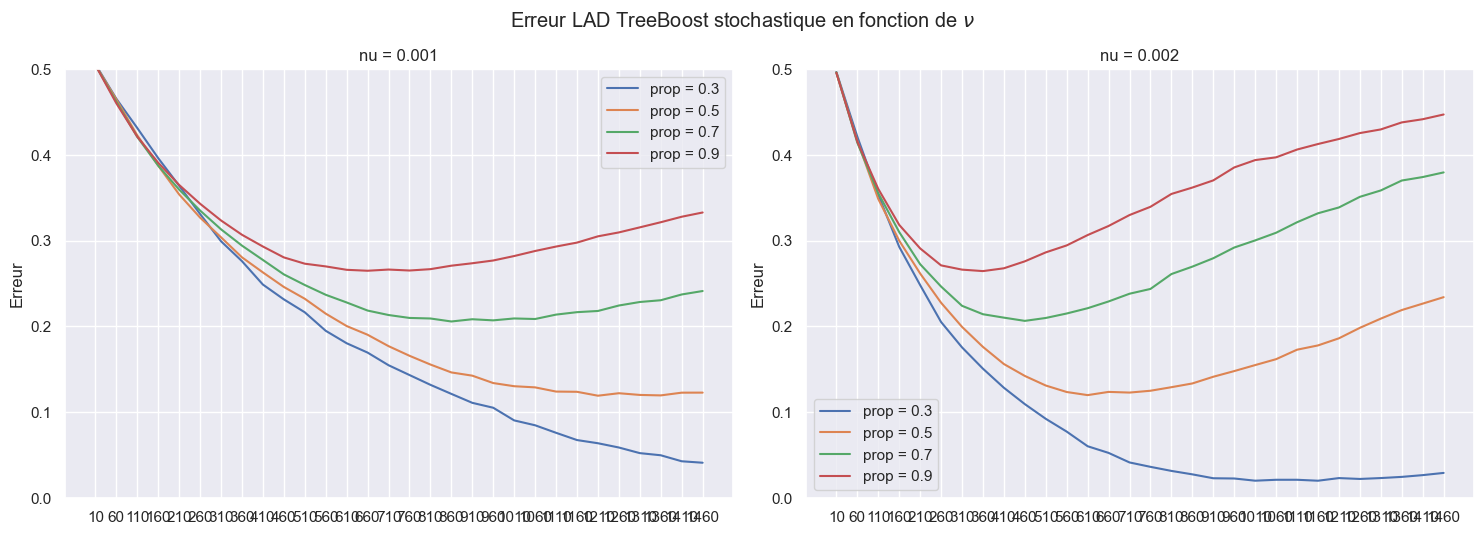

In [11]:
# Définir la graine pour assurer la reproductibilité
np.random.seed(seed)
# Définir les paramètres
Max_samples = [0.3,0.5,0.7,0.9] #Proportions d'échantillons utilisés pour l'entraînement
Nu = [0.001,0.002] # Taux d'apprentissage
N_est = np.arange(10,1500,50) # Nombre d'apprenants faibles
# Créer une figure de taille 15x10
plt.figure(figsize=(15,10))
# Boucle sur chaque proportion d'échantillons
for m in Max_samples:
    # Boucle sur chaque valeur de nu
    for it,nu in enumerate(Nu):
        plt.subplot(2,2,it+1)# Ajouter un subplot# Liste pour stocker les erreurs
        # Boucle sur chaque nombre d'apprenants faibles
        err = []# Liste pour stocker les erreurs
        # Boucle sur chaque nombre d'apprenants faibles
        for n_est in N_est:   
             # Initialiser et entraîner le modèle GradientBoostingTree avec la perte LAD
            reg = GradientBoostingTree(loss='LAD',learning_rate=nu, n_estimators=n_est, criterion='friedman_mse', max_depth=9, max_samples=m)
            reg.starter(X_train,y_train)
             # Faire des prédictions sur les données de test
            y_pred_lad=reg.predict(X_test)
            err.append(reg.error(X_test,y_test))# Ajouter l'erreur aux erreurs
        i_min = np.argmin(np.array(err)) # Trouver l'indice de l'erreur minimale
        plt.plot(N_est, err, label=f'prop = {m:.1f}')# Tracer les erreurs
        if it > 5 :
            plt.xlabel('Nombre de weak learners')
        plt.xticks(N_est, [str(N) for N in N_est])
        plt.ylabel('Erreur')
        plt.ylim(0,0.5)
        plt.title(f'nu = {nu:.3f}')
        plt.legend()
    plt.suptitle(r'Erreur LAD TreeBoost stochastique en fonction de $\nu$')
plt.tight_layout();# Ajuster la disposition pour éviter le chevauchement
# Ajouter le titre à la figure


### Remarques:
Pour chaque valeur de n_est (nombre d'apprenants faibles), un modèle GradientBoostingTree est créé et entraîné avec la perte LAD.
Les prédictions sont faites sur les données de test, et les erreurs sont calculées et stockées.

Les erreurs sont tracées pour chaque combinaison de m et nu.

Remarque:Ce code permet de visualiser l'effet de différentes proportions d'échantillons et de taux d'apprentissage sur les erreurs du modèle Gradient Boosting avec la perte LAD, en utilisant un nombre variable d'apprenants faibles.

En effet, en doublant  𝜈
  on remarque déjà que l'on tombe dans l'overfitting. Le rôle de  𝜈
  est crucial pour le bon entraînement du GradientBoostingTree, sur ce jeu de données en particulier. Néanmoins, pour le cas  𝜈=10−3
 , les courbes ne semblent pas avoir atteint leur optimum (sauf pour  𝜌=0.3
 , la courbe bleue semble recrôitre). La poursuite de l'entraînement en construisant d'autres arbres pourrait sans doute conduire à une meilleure convergence en erreur de test. Comme précédemment, on peut représenter l'approximation de la fonction  𝑓∗=sin
  :

Time :6.8095 sec
Time :12.8537 sec
Time :18.6760 sec
Time :25.2641 sec


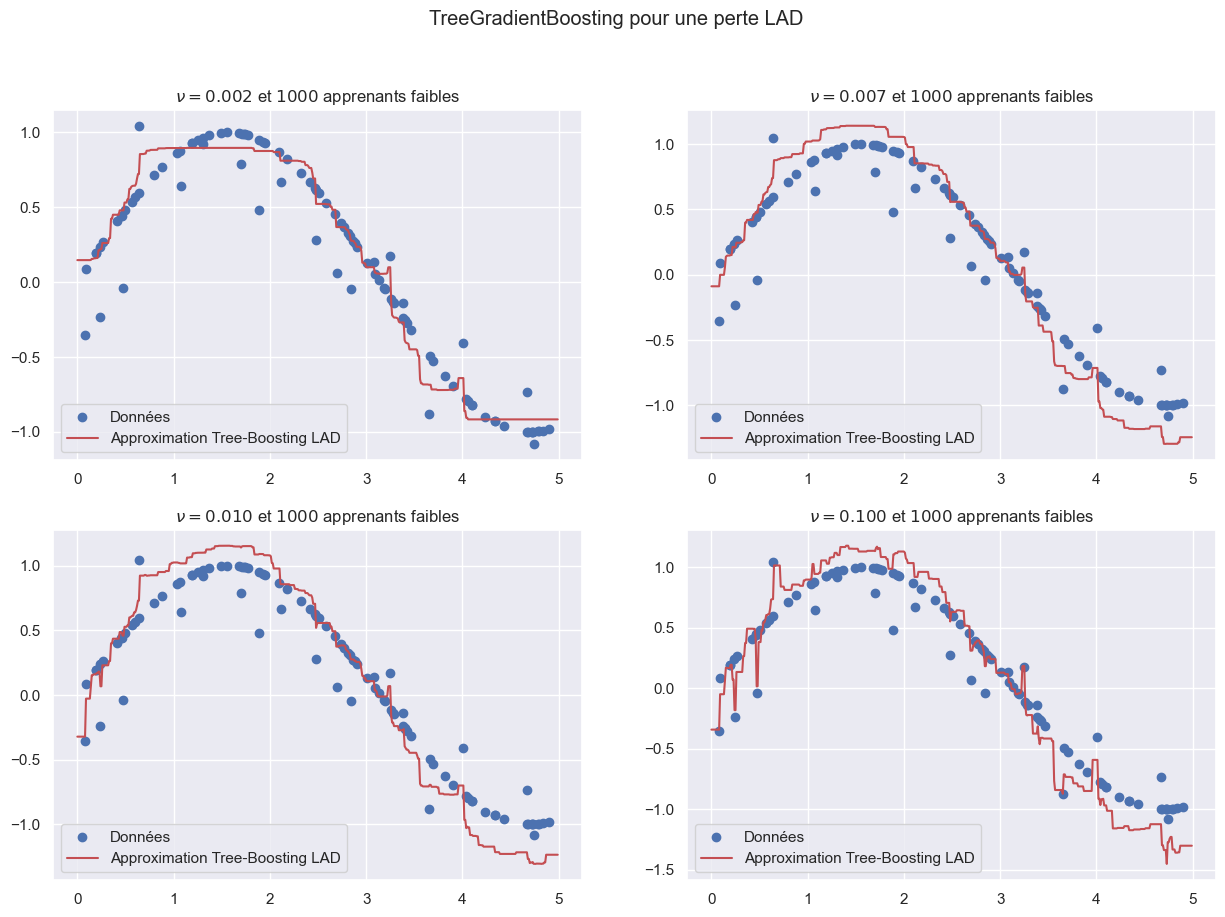

In [12]:
np.random.seed(seed)
Nu = [0.002, 0.007, 0.01, 0.1]  # Taux d'apprentissage
N_weak_learners = 1000 # Nombre d'apprenants faibles
prop = 0.8# Proportion d'échantillons utilisés pour l'entraînement
t0 = perf_counter() # Démarrer le compteur de temps

plt.figure(figsize=(15,5*math.ceil(len(Nu)/2))) # Créer une figure de taille 15x(5*nombre de lignes de subplots)
# Boucle sur chaque valeur de nu
for it,nu in enumerate(Nu):
    # Ajouter un subplot
    plt.subplot(math.ceil(len(Nu)/2),2,it+1)
     # Initialiser et entraîner le modèle GradientBoostingTree avec la perte LAD
    reg = GradientBoostingTree(loss='LAD',learning_rate=nu, n_estimators=N_weak_learners, criterion='friedman_mse', max_depth=3, max_samples=prop)
    reg.starter(X_train, y_train)
    # Faire des prédictions sur les données de test
    y_pred_mse = reg.predict(X_test)
     # Tracer les données d'entraînement et les prédictions
    plt.scatter(X_train, y_train, label = 'Données')
    plt.plot(X_test, y_pred_mse, 'r',label='Approximation Tree-Boosting LAD')
    # Ajouter un titre et une légende
    plt.title(fr"$\nu ={nu:.3f}$ et ${N_weak_learners}$ apprenants faibles")
    plt.legend()
    # Afficher le temps écoulé
    t1 = perf_counter()
    print(f'Time :{t1-t0:.4f} sec')
    # Ajouter un titre principal à la figure
plt.suptitle("TreeGradientBoosting pour une perte LAD");

### Explications détaillées :

Démarrage du compteur de temps :

t0 = perf_counter() permet de mesurer le temps d'exécution du code. Création de la figure :

La figure est configurée pour avoir une taille de 15x(5*nombre de lignes de subplots), ce qui permet de disposer les subplots de manière ordonnée. Boucle sur les valeurs de Nu :

Pour chaque valeur de nu (taux d'apprentissage), un subplot est ajouté. Un modèle GradientBoostingTree est créé et entraîné avec la perte LAD. Les prédictions sont faites sur les données de test. Tracé des résultats :

Les données d'entraînement et les prédictions sont tracées.

Le temps écoulé est affiché.

Ce code permet de visualiser l'effet de différents taux d'apprentissage sur les prédictions du modèle Gradient Boosting avec la perte LAD, en utilisant un nombre fixe d'apprenants faibles et une proportion fixe d'échantillons pour l'entraînement.

### Dataset MNIST 
Ici on considère le problème de classification  1
  vs all qui consiste à entraîner un modèle pour distinguer les  0
  des autres digits.

In [13]:
import os
import pandas as pd
import zipfile

# Chemin de l'archive ZIP contenant les fichiers CSV
zip_path = r'C:\Users\Lass\Documents\MES R_PROJETS 2024\archive (4).zip'

# Chemin du dossier où les fichiers seront extraits
extract_folder = r'C:\Users\Lass\Documents\MES R_PROJETS 2024\mnist_data'

# Vérifiez si le dossier de destination existe, sinon créez-le
if not os.path.exists(extract_folder):
    os.makedirs(extract_folder)

# Extraire l'archive ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Chemins complets des fichiers CSV extraits
train_file_path = os.path.join(extract_folder, 'mnist_train.csv')
test_file_path = os.path.join(extract_folder, 'mnist_test.csv')

# Vérification et affichage des chemins
print(f"Chemin du fichier d'entraînement: {train_file_path}")
print(f"Chemin du fichier de test: {test_file_path}")

# Lire les fichiers CSV et charger dans des DataFrames pandas
try:
    mnist_train = pd.read_csv(train_file_path, header=None)
    mnist_test = pd.read_csv(test_file_path, header=None)
except FileNotFoundError as e:
    print(f"Erreur: {e}")
    # Afficher le contenu du dossier pour débogage
    print(f"Contenu du dossier {extract_folder}: {os.listdir(extract_folder)}")
    mnist_train, mnist_test = None, None
except Exception as e:
    print(f"Une erreur est survenue: {e}")
    mnist_train, mnist_test = None, None

# Conversion des DataFrames pandas en tableaux NumPy si les fichiers ont été chargés avec succès
if mnist_train is not None and mnist_test is not None:
    mnist_train = mnist_train.to_numpy()
    mnist_test = mnist_test.to_numpy()
    print("Les données ont été chargées et converties avec succès.")
else:
    print("Échec du chargement des données.")

Chemin du fichier d'entraînement: C:\Users\Lass\Documents\MES R_PROJETS 2024\mnist_data\mnist_train.csv
Chemin du fichier de test: C:\Users\Lass\Documents\MES R_PROJETS 2024\mnist_data\mnist_test.csv


C:\Users\Lass\AppData\Local\Temp\ipykernel_6724\2605462631.py:29: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,2

Les données ont été chargées et converties avec succès.


C:\Users\Lass\AppData\Local\Temp\ipykernel_6724\2605462631.py:30: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,2

In [14]:
# Test
reg = GradientBoostingTree(loss='LK',learning_rate=1, n_estimators=1, criterion='friedman_mse', max_depth=3, max_samples=1)
reg.starter(X_train,y_train)#Entraîne le modèle sur les données d'entraînement.
err = reg.error(X_test,y_test)# Calculer l'erreur du modèle sur les données de test.
err #afficher l'erreur du modèle sur l'ensemble de test.

0.012

In [15]:
# Test with stochastic version
reg = GradientBoostingTree(loss='LK',learning_rate=1, n_estimators=10, criterion='friedman_mse', max_depth=11, max_samples=0.1)
reg.starter(X_train,y_train)
err = reg.error(X_test,y_test)
err

0.012

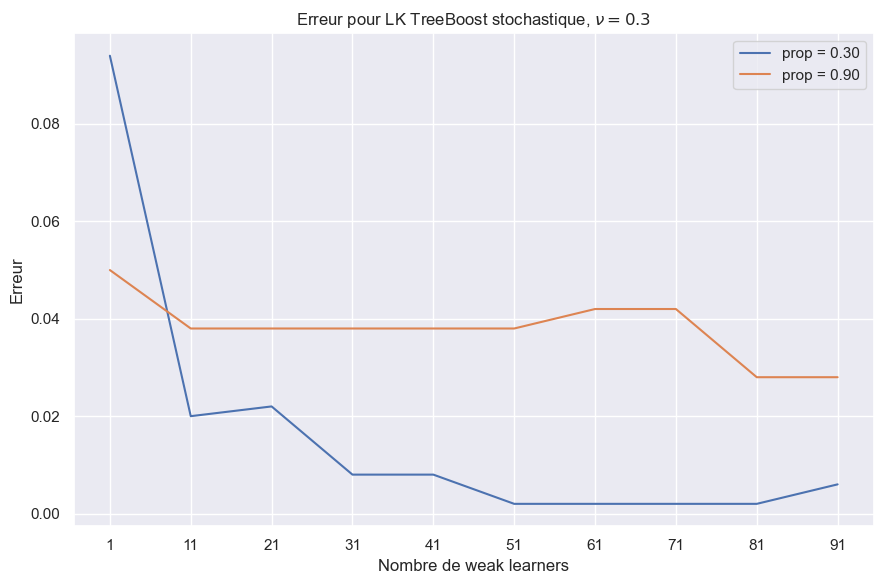

In [17]:
seed=42
np.random.seed(seed)
from time import perf_counter 
Max_samples = [0.3,0.9] # Proportions d'échantillons pour l'entraînement
nu = 0.3 # Taux d'apprentissage
N_est = np.arange(1, 100, step=10) # Nombre d'apprenants faibles

plt.figure(figsize=(9,6)) # Définir la taille de la figure

# Boucle sur les différentes proportions d'échantillons
for m in Max_samples:
    err = []  # Liste pour stocker les erreurs
    for n_est in N_est:
        # Initialisation du modèle GradientBoostingTree
        reg = GradientBoostingTree(loss='LK',learning_rate=nu, n_estimators=n_est, criterion='friedman_mse', max_depth=3, max_samples=m)
        reg.starter(X_train,y_train)  # Entraînement du modèle
        err.append(reg.error(X_test,y_test))  # Calcul de l'erreur sur l'ensemble de test
    i_min = np.argmin(np.array(err)) # Trouver l'indice de l'erreur minimale
    plt.plot(N_est, err, label=f'prop = {m:.2f}') # Tracer l'erreur en fonction du nombre d'apprenants faibles
    # Configuration des axes et légende
    plt.xlabel('Nombre de weak learners')
    plt.xticks(N_est, [str(N) for N in N_est])
    plt.ylabel('Erreur')  # l'étiquette 
        #plt.ylim(0,0.5)
#plt.title(f'nu = {nu:.2f}')
    plt.legend()
    plt.title(fr'Erreur pour LK TreeBoost stochastique, $\nu = {nu:.1f}$')# Titre du graphique
plt.tight_layout();# Ajuster la disposition pour éviter le chevauchement

# Dataset diabètes `scikit` <a id="part5"></a>
Ici, on décide de tester notre méthode `GradientBoostingTree` sur des données (médicales) fournies par la bibliothèque `scikit-learn`. Pour plus d'informations au sujet du dataset considéré, on peut se référer à [Diabetes dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html) et [Adaboost on diabetes dataset](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html).

In [18]:
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
# Charger les données
data = load_diabetes()
X, y = data.data, data.target
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, test_size=0.1)
# Normaliser les caractéristiques
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = scaler.fit_transform(y_train.reshape(-1, 1))[:, 0]
y_test = scaler.transform(y_test.reshape(-1, 1))[:, 0]

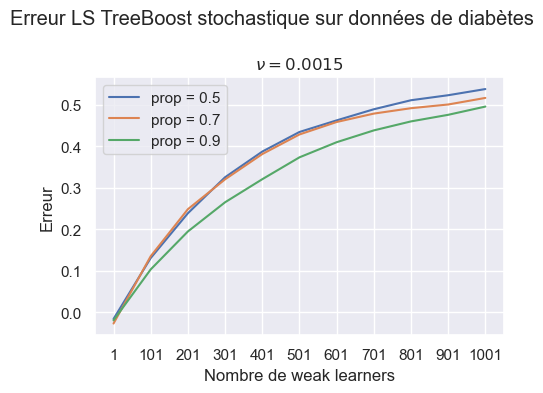

In [19]:
# Définir la graine pour la reproductibilité des résultats
np.random.seed(42)

# Paramètres pour l'échantillonnage et le nombre d'estimateurs
Max_samples = [0.5, 0.7, 0.9]  # Proportions de données utilisées pour entraîner chaque arbre
nu = 0.0015  # Taux d'apprentissage
N_est = np.arange(1, 1002, step=100)  # Plage des nombres d'estimateurs (arbre)
N_grid = np.arange(1, 1002, step=100)  # Plage pour les labels des ticks de l'axe des x

# Initialiser la figure pour les graphiques
plt.figure(figsize=(5, 4))

# Boucle sur les différentes proportions d'échantillons
for m in Max_samples:
    err = []  # Liste pour stocker les erreurs pour chaque nombre d'estimateurs
    for n_est in N_est:
        # Créer le modèle Gradient Boosting avec les paramètres spécifiés
        reg = GradientBoostingRegressor(
            loss='squared_error',  # Fonction de perte des moindres carrés
            learning_rate=nu,  # Taux d'apprentissage
            n_estimators=n_est,  # Nombre d'estimateurs (arbres)
            criterion='friedman_mse',  # Critère de qualité des splits (par défaut pour la régression)
            max_depth=5  # Profondeur maximale des arbres
        )
        
        # Entraîner le modèle avec sous-échantillonnage des données si nécessaire
        if m < 1:
            sample_size = int(X_train.shape[0] * m)
            X_train_sub, _, y_train_sub, _ = train_test_split(X_train, y_train, train_size=sample_size, random_state=42)
        else:
            X_train_sub, y_train_sub = X_train, y_train  # Utiliser toutes les données si m = 1
        
        reg.fit(X_train_sub, y_train_sub)
        # Calculer l'erreur sur les données de test
        err.append(reg.score(X_test, y_test))  # Utiliser score pour obtenir la performance du modèle

    # Tracer les erreurs en fonction du nombre d'estimateurs
    plt.plot(N_est, err, label=f'prop = {m:.1f}')
    
    # Ajouter des labels et des ticks sur les axes
    plt.xlabel('Nombre de weak learners')
    plt.xticks(N_grid, [str(N) for N in N_grid])
    plt.ylabel('Erreur')
    plt.title(fr'$\nu = {nu:.4f}$')
    plt.legend()

# Ajouter un titre global pour le graphique
plt.suptitle(f'Erreur LS TreeBoost stochastique sur données de diabètes')

# Ajuster la mise en page pour éviter les chevauchements
plt.tight_layout()
plt.show()  # Afficher le graphique

On peut notamment comparer nos résultats à d'autres méthodes d'apprentissage par aggrégation ou bagging (BaggingRegressorou RandomForestRegressor) qui, pour la plupart, ne fournissent pas de résultats très performants, puisqu'ils n'atteignent pas 0.5 en précision comme il est le cas pour notre GradientBoostingTree.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor

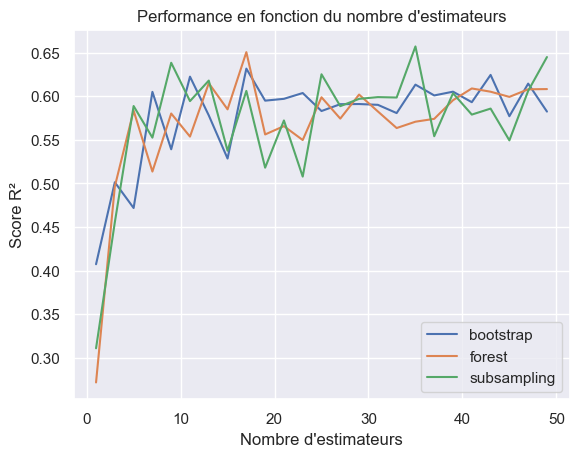

In [21]:
# Paramètres
depth = 5
params = {"max_depth": depth}

# Plage d'estimateurs
estim = np.arange(1, 50, step=2)

# Initialisation de la figure
plt.figure()

# Boucle sur les différents régresseurs
for name, reg in [("bootstrap", BaggingRegressor(estimator=DecisionTreeRegressor(**params),
                                                 max_samples=1.0, bootstrap=True)),
                  ("forest", RandomForestRegressor(**params)),
                  ("subsampling", BaggingRegressor(estimator=DecisionTreeRegressor(**params),
                                                   max_samples=0.25, bootstrap=False))]:
    score = []
    for T in estim:
        reg.set_params(n_estimators=T)  # Utiliser set_params pour éviter les problèmes
        reg.fit(X_train, y_train)
        score.append(reg.score(X_test, y_test))
    plt.plot(estim, score, label=name)

# Affichage des résultats
plt.legend(loc="best")
plt.xlabel("Nombre d'estimateurs")
plt.ylabel("Score R²")
plt.title("Performance en fonction du nombre d'estimateurs")
plt.show()

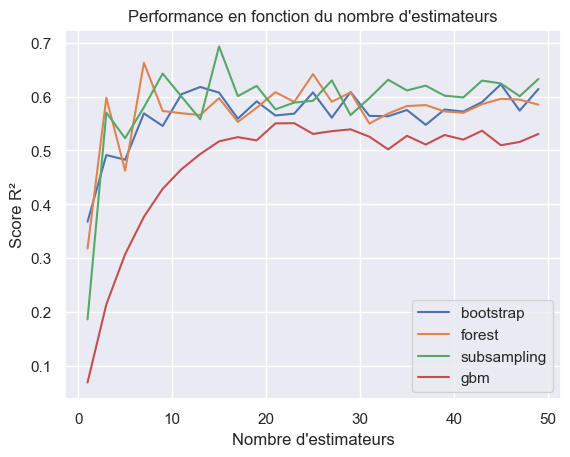

In [22]:
# Paramètres
depth = 5
params = {"max_depth": depth}

# Plage d'estimateurs
estim = np.arange(1, 50, step=2)

# Initialisation de la figure
plt.figure()

# Boucle sur les différents régresseurs
for name, reg in [("bootstrap", BaggingRegressor(estimator=DecisionTreeRegressor(**params),
                                                 max_samples=1.0, bootstrap=True)),
                  ("forest", RandomForestRegressor(**params)),
                  ("subsampling", BaggingRegressor(estimator=DecisionTreeRegressor(**params),
                                                   max_samples=0.25, bootstrap=False)),
                  ("gbm", GradientBoostingRegressor(max_depth=depth))]:  # Ajouter GradientBoostingRegressor ici
    score = []
    for T in estim:
        reg.set_params(n_estimators=T)  # Utiliser set_params pour éviter les problèmes
        reg.fit(X_train, y_train)
        score.append(reg.score(X_test, y_test))
    plt.plot(estim, score, label=name)

# Affichage des résultats
plt.legend(loc="best")
plt.xlabel("Nombre d'estimateurs")
plt.ylabel("Score R²")
plt.title("Performance en fonction du nombre d'estimateurs")
plt.show()